# Introduction to scikit-learn

Broadly speaking, we can categorize machine learning algorithms into three groups: *supervised learning*, *unsupervised learning*, and *reinforcement learning*.
In the remainder of this course, we'll focus on the first category, and we'll study how we can use the supervised learning algorithms implemented in
[scikit-learn](https://scikit-learn.org/stable/index.html), as popular machine learning library for Python.

Supervised learning uses input data (often called independent variables, features, 
covariates, predictors, or $X$ variables) and the corresponding output data 
(dependent variable, outcome, target, or $y$ variable) to establish some relationship 
$y = f(X)$ within a training data set. We can then use this relationship to make
predictions about outputs in new data.

Within supervised learning, we distinguish two broad types of approaches:

1. Regression, where output data is allowed to take on continuous values; and
2. Classification, where output data is restricted to a few values,
  often called categories or labels.

Unlike in standard econometric, regression and classification usually include a penalty term which helps improve the predictive performance of these models on new data. We will study this setting in the next lecture.

***
## Univariate linear regression

Imagine the simplest linear model where the dependent variable $y$ is
assumed to be an affine function of the explanatory variable $x$
and an error term $\epsilon$, given by
$$
y_i = \alpha + \beta x_i + \epsilon_i
$$
for each observation $i$.
In econometrics, the parameters $\alpha$ and $\beta$ are called the intercept and
slope parameters, respectively. In machine learning, the terminology
often differs and you might see the same model written as
$$
y_i = b + w x_i + \epsilon_i
$$
where $b$ is called the *bias* and $w$ is called a *weight*. 

Our goal is to estimate the parameters $\alpha$ and $\beta$ which is
most commonly done by ordinary least squares (OLS). OLS is defined as the
estimator that finds the estimates $(\widehat{\alpha}, \widehat{\beta})$
such that the sum of squared errors is minimized,
$$
L(\alpha, \beta) = \frac{1}{N}
    \sum_i^N \Bigl(y_i - \alpha - \beta x_i \Bigr)^2
$$
where $L$ is the loss function that depends on the choice of parameters. Note that
we use the "hat" notation $\widehat{\alpha}$ to distinguish the OLS
estimate from the (usually unknown) true parameter $\alpha$. The exact
values of $\widehat{\alpha}$ and $\widehat{\beta}$ will vary depending the sample 
size and estimator used as we will see later in this unit.

For this simple model, the estimates are given by the expressions
$$
\begin{aligned}
\widehat{\beta} &= \frac{\widehat{Cov}(y,x)}{\widehat{Var}(x)} \\
\widehat{\alpha} &= \overline{y} - \widehat{\beta} \overline{x}
\end{aligned}
$$
where $\widehat{Cov}(\bullet,\bullet)$ and $\widehat{Var}(\bullet)$ are the *sample* covariance and
variance, respectively, and $\overline{y}$ and $\overline{x}$ are the sample
means of $y$ and $x$. 

There is a straightforward generalization to
the multivariate setting where we have a vector $\mathbf{x}_i$ of explanatory variables 
(which usually include the intercept) and a parameter vector
$\mathbf{\beta}$ so that the model is given by
$$
y_i = \mathbf{x}_i'\mathbf{\beta} + \epsilon_i
$$
If we stack all $\mathbf{x}_i$ in the matrix $\mathbf{X}$ and all $y_i$ in 
the vector $\mathbf{y}$, the OLS estimate 
of $\mathbf{\beta}$ is given by the well-known formula
$$
\widehat{\mathbf{\beta}} = \left(\mathbf{X}'\mathbf{X}\right)^{-1} \mathbf{X}'\mathbf{y}
$$

We won't be estimating linear regressions based on this formula and you should never attempt this, as naively implementing such matrix operations can lead to numerical problems. Instead, always use pre-packaged least-squares solvers such as those implemented in NumPy's [`lstsq()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) or
SciPy's [`lstsq()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html)
functions. 
For econometrics and machine learning, it usually makes sense to use linear regression models such as those implemented in 
[`statsmodels`](https://www.statsmodels.org/stable/regression.html) or
[`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html),
which is what we turn to next.

***
### Univariate linear regressions with scikit-learn

We start by fitting the simple linear model
$$
y_i = \alpha + \beta x_i + \epsilon_i
$$
using `scikit-learn`. For now, we proceed using synthetically generated data where we know the true relationship, assuming that
$$
\begin{aligned}
y_i &= 1 + \frac{1}{2} x_i + \epsilon_i \\
\epsilon_i &\stackrel{\text{iid}}{\sim} N(0, \sigma^2)
\end{aligned}
$$
so that the true parameters are $\alpha = 1$ and $\beta = \frac{1}{2}$. The error term $\epsilon_i$ is assumed to be normally distributed with mean $0$ and variance $\sigma^2$ which we set to $\sigma^2 = 0.07^2$ for this example.

We generate a sample of $N=50$ observations as follows:

In [1]:
import numpy as np
from numpy.random import default_rng

# Generate RNG instance with seed 1234
rng = default_rng(seed=1234)

# Number of observations
N = 50

# True parameters
alpha = 1.0
beta = 0.5
sigma = 0.7

# Use x that are uniformly distributed on [0, 10]
x = rng.uniform(0, 10, size=N)

# Normally distributed errors
epsilon = rng.normal(scale=sigma, size=N)

# Create outcome variable
y = alpha + beta * x + epsilon

To fit a linear model, we use the 
[`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class provided by `scikit-learn`. Before doing so, we need to import it from `sklearn.linear_model`.
Note that most fitting routines in `scikit-learn` expect a *matrix* as opposed to a vector even if the model has only one explanatory variable, so we need to insert an artificial axis to create the matrix `X = x[:, None]`.

In [2]:
from sklearn.linear_model import LinearRegression

# Create LinearRegression object
lr = LinearRegression(fit_intercept=True)

# fit() expects two-dimensional object, convert x to N x 1 matrix
X = x[:, None]

# Fit model to data
lr.fit(X, y)

# Predict fitted values
yhat = lr.predict(X)

Note that `scikit-learn` models usually store the fitted model parameters in the `coef_` attribute (which is an array even if there is only a single explanatory variable). If the model includes an intercept, its fitted value is stored in the attribute `intercept_`:

In [3]:
# Extract parameter estimates from LinearRegression object
alpha_hat = lr.intercept_
beta_hat = lr.coef_[0]

print(f'Estimated alpha: {alpha_hat:.3f}')
print(f'Estimated beta: {beta_hat:.3f}')

Estimated alpha: 1.376
Estimated beta: 0.482


The following code visualizes the sample as a scatter plot of $(x_i, y_i)$ and adds the fitted line (in solid orange). Intuitively, for $x=0$ the fitted line has the value $\widehat{\alpha}$ (the intercept) and its slope is equal to $\widehat{\beta}$. 

Text(0.5, 1.0, 'Univariate linear regression')

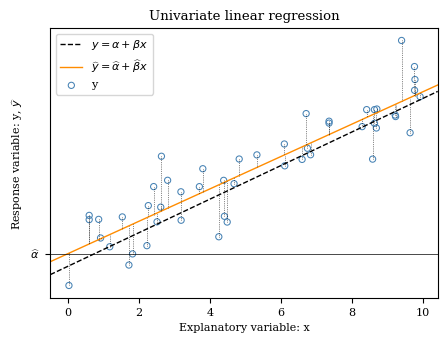

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3.5))

# Plot true relationship
plt.axline(
    (0.0, alpha), slope=beta, lw=1.0, ls='--', c='black', 
    label=r'$y = \alpha + \beta x$'
)

# Plot regression line
plt.axline(
    (0.0, alpha_hat), slope=beta_hat, lw=1.0, c='darkorange', 
    label=r'$\widehat{y} = \widehat{\alpha} + \widehat{\beta} x$'
)

# Plot raw data
plt.scatter(
    x, y, s=20, color='none', edgecolor='steelblue', alpha=1.0, lw=0.75, label='y'
)

# Plot lines connecting true and predicted values for
# each observation
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], yhat[i]], lw=0.5, ls=':', c='black', alpha=0.9)

# Add annotations
plt.xlabel('Explanatory variable: x')
plt.ylabel(r'Response variable: y, $\widehat{y}$')
plt.axhline(alpha_hat, lw=0.5, c='black')
plt.legend(loc='best')
plt.yticks((alpha_hat,), (r'$\widehat{\alpha}$',))

plt.title('Univariate linear regression')

The dashed black line shows the true relationship which is known in this synthetic sample, but in general is unknown for real data. For small sample sizes, the true and estimated parameters need not be close as the graph illustrates. The graph also shows the prediction errors as the dotted lines between the sample points $y_i$ and the black fitted model. OLS minimizes the sum of the squares of these distances.

<div class="alert alert-info">
<h3> Your turn</h3>
<ol>
    <li>Recreate and re-estimate the model for samples of size 10, 50, 100, 1000, and 10000.</li>
    <li>Print the estimated values of α and β. Can you say something about the deviation from the true values as the sample size increases?</li>
</ol>
</div>

***
### Training and test samples

In econometrics, we usually emphasize *inference*, i.e., we are interested in testing a hypothesis about the estimated parameter, for example whether it is statistically different from zero. Conversely, in machine learning the emphasis is often on prediction, i.e., our goal is to estimate a relationship from a *training* sample and make predictions for new data. Usually, we use a *test* sample that is different from the training data to assess how well our model is able to predict outcomes for new data which has not been used for estimation.

To demonstrate the use of training and test data sets, we use as simplified variant of the 
[Ames house price data set](https://www.openml.org/d/42165) 
which can be obtained from [openml.org](https://www.openml.org), a repository for free-to-use data suitable for machine learning tasks.

The original data set has 80 features (explanatory variables) which are characteristics of houses in Ames, a city of about 60 thousand inhabitants in the middle of Iowa, USA. The goal is to use these features to predict the house price (or "target" in ML terminology). The above website provides details on all 80 features, but we restrict ourselves to a small subset.

We could download the data set directly from [openml.org](https://www.openml.org) using `scikit-learn` as follows:

In [5]:
from sklearn.datasets import fetch_openml
ds = fetch_openml(name='house_prices')

X = ds.data         # Get features (explanatory variables)
y = ds.target       # get dependent variable

This returns an object with various information about the data set. The features are stored in the `data` attribute, while the dependent variable is stored in the `target` attribute.

Instead, we will use a local copy of the simplified data set which contains only a subset of 12 features that are slightly adapted for our purposes.

In [6]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data'

# Load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/FIE463-V25/main/data'

In [7]:
import pandas as pd

file = f'{DATA_PATH}/ames_houses.csv'
df = pd.read_csv(file)

# List columns present in DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   SalePrice         float64
 1   LotArea           float64
 2   Neighborhood      object 
 3   BuildingType      object 
 4   OverallQuality    int64  
 5   OverallCondition  int64  
 6   YearBuilt         int64  
 7   CentralAir        object 
 8   LivingArea        float64
 9   Bathrooms         int64  
 10  Bedrooms          int64  
 11  Fireplaces        int64  
 12  HasGarage         int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 148.4+ KB


In this section, we focus on the columns `SalePrice` which contains the house price in thousands of US dollars and `LivingArea` which contains the living area in $m^2$ for each house in the sample. To get some intuition for the data, we look at some descriptive statistics:

In [8]:
df[['SalePrice', 'LivingArea']].describe()

,SalePrice,LivingArea
count,1460.000000,1460.000000
mean,180.921196,140.777444
std,79.442503,48.813961
min,34.900000,31.026587
25%,129.975000,104.923743
50%,163.000000,135.996777
75%,214.000000,165.049367
max,755.000000,524.107798


For our analysis, extract the target (`SalePrice`) and the features (`LivingArea`) from the data set.

In [9]:
features = ['LivingArea']
target = 'SalePrice'

# Create separate Series / DataFrames for target and features
y = df[target]
X = df[features]

#### Automatically creating training and test samples

Instead of splitting the sample manually into training and test sub-samples, we use `scikit-learn`'s
[`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
to automate this task. We need to either specify the `test_size` or `train_size` arguments to determine how the sample should be (randomly) split. The `random_state` argument is used to seed the RNG and get reproducible results:

In [10]:
from sklearn.model_selection import train_test_split

# fraction of data used for test sample
test_size = 0.3

# Split into training / test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,    # Fraction used for test sample
    random_state=1234,       # Seed for random number generator
)

Once we have split the sample, we estimate the model on the training sample.

In [11]:
from sklearn.linear_model import LinearRegression

# Fit model on training sample
lr = LinearRegression()
lr.fit(X_train, y_train)

# Extract estimated parameters
intercept = lr.intercept_
slope = lr.coef_[0]

print('Regression coefficients')
print(f'  Intercept: {intercept:.1f}')
print(f'  Slope: {slope:.1f}')

Regression coefficients
  Intercept: 17.6
  Slope: 1.2


The fitted coefficients show that for each additional square meter of living area, the sale price on average increases by approximately $1,100.

The following code creates a scatter plot showing the training and test samples and adds the fitted line.

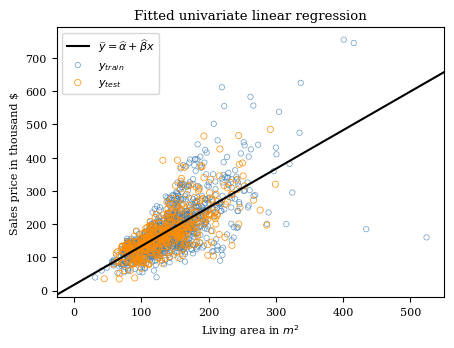

In [12]:
plt.subplots(figsize=(5, 3.5))

# Plot regression line
plt.axline((0.0, intercept), slope=slope, lw=1.5, c='black', 
    label=r'$\widehat{y} = \widehat{\alpha} + \widehat{\beta} x$')

# Plot training data
plt.scatter(X_train, y_train, s=15, color='none', edgecolor='steelblue', 
    alpha=0.8, lw=0.5, label=r'$y_{train}$')

# Plot test data
plt.scatter(X_test, y_test, s=20, color='none', edgecolor='darkorange', 
    alpha=1.0, lw=0.5, label=r'$y_{test}$')

# Add annotations
plt.xlabel('Living area in $m^2$')
plt.ylabel(r'Sales price in thousand $')
plt.title('Fitted univariate linear regression')
plt.legend(loc='best')


Since this is a univariate model, we can also plot the prediction error against the explanatory variable $x$. For this, we first need to compute the predicted values in the test sample and then the prediction error for each observations,
$$
\epsilon_i = y_i - \widehat{y}_i = y_i - \widehat{\alpha} - \widehat{\beta} x_i
$$
for all $i$ that are part of the test sample.

In [13]:
# Predict model for test sample
y_test_hat = lr.predict(X_test)

# Prediction error for test sample
error = y_test - y_test_hat

We can now plot the predition errors against the living area:

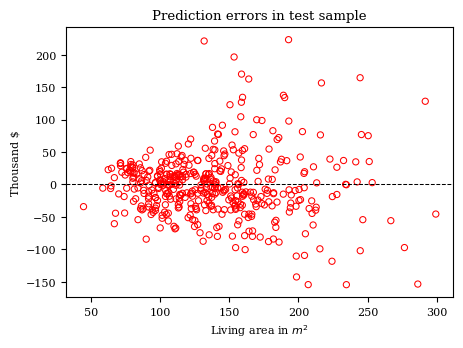

In [14]:
plt.figure(figsize=(5, 3.5))

# Scatter plot of prediction errors
plt.scatter(X_test, error, s=20, color='none', edgecolor='red', alpha=1.0, lw=0.75)

# Add annotations
plt.xlabel('Living area in $m^2$')
plt.ylabel(r'Thousand $')
plt.title('Prediction errors in test sample')
plt.axhline(0.0, lw=0.75, ls='--', c='black')

As the graph shows, the errors are reasonably centred around $0$ as we would expect from a model that contains an intercept. However, the error variance seems to be increasing in $x$ which indicates that our model might be missing some explanatory variables.

***
## Multivariate linear regression

### Data with several explanatory variables

Multivariate (or multiple) linear regression extends the simple model to multiple explanatory variables or regressors. To illustrate, we'll load the Ames housing data again but use several (continuous) explanatory variables.

In [15]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data'

# Load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/FIE463-V25/main/data'

In [16]:
import pandas as pd

# Load data from CSV file
file = f'{DATA_PATH}/ames_houses.csv'
df = pd.read_csv(file)

# Print info about columns contained in DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   SalePrice         float64
 1   LotArea           float64
 2   Neighborhood      object 
 3   BuildingType      object 
 4   OverallQuality    int64  
 5   OverallCondition  int64  
 6   YearBuilt         int64  
 7   CentralAir        object 
 8   LivingArea        float64
 9   Bathrooms         int64  
 10  Bedrooms          int64  
 11  Fireplaces        int64  
 12  HasGarage         int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 148.4+ KB


Compared to our earlier analysis, we'll now add the lot area (in $m^2$) as a feature to the model, which is thus given by
$$
SalePrice_i = \alpha + \beta_0 LivingArea_i + \beta_1 LotArea_i + \epsilon_i
$$

We first inspect the descriptive statistics of the newly added explanatory variable to get some idea about its distribution.

In [17]:
df[['SalePrice', 'LivingArea', 'LotArea']].describe()

,SalePrice,LivingArea,LotArea
count,1460.000000,1460.000000,1460.000000
mean,180.921196,140.777444,976.949947
std,79.442503,48.813961,927.199358
min,34.900000,31.026587,120.762165
25%,129.975000,104.923743,701.674628
50%,163.000000,135.996777,880.495526
75%,214.000000,165.049367,1077.709432
max,755.000000,524.107798,19994.963289


As before, we extract the target and features, and split the data into training and test samples.

In [18]:
from sklearn.model_selection import train_test_split

features = ['LivingArea', 'LotArea']
target = 'SalePrice'

y = df[target]
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1234
)

Fitting the model on the training data is the same as in the univariate case:

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'Intercept: {lr.intercept_}')
print(f'Coefficients: {lr.coef_}')

Intercept: 16.1791337262934
Coefficients: [1.12865792 0.00636943]


The coefficient array `coef_` now stores two values, the first one for `LivingArea` and the second one for `LotArea`. These coefficients are in the same order as the features in the feature matrix $\mathbf{X}$ passed when fitting the model.

Since we now have multiple explanatory variables, we can no longer easily plot prediction errors against one feature unless we fix the remaining features at some value or use 3D scatter plots. The latter of course does not help if we have more than two explanatory variables. Instead, we can plot the prediction errors against $y$ which we do below.

In [20]:
# Predict values in test sample
y_test_hat = lr.predict(X_test)

# Compute prediction errors
errors = y_test - y_test_hat

We can now plot these prediction errors against the target $y$:

Text(0, 0.5, 'Thousand $')

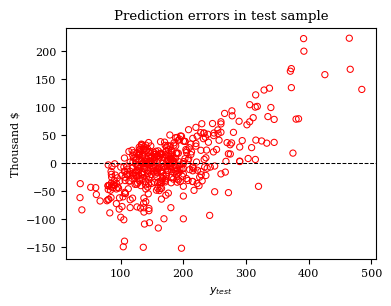

In [21]:
import matplotlib.pyplot as plt

plt.scatter(y_test, errors, s=20, lw=0.75, color='none', edgecolor='red')
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.title('Prediction errors in test sample')
plt.xlabel(r'$y_{test}$')
plt.ylabel('Thousand $')

The scatter plot indicates that the prediction errors differ systematically for different levels of $y$. The model on average overpredicts the sale price for low $y$ (hence the error is negative) and underpredicts the price for large $y$ (hence the error is positive).

***
### Creating polynomial features

Instead of including additional explanatory variables, we can also create additional terms that are functions of variables. The most common way to do this is to include a polynomial in $x$ (or polynomials in multiple explanatory variables). Thus a simple model could be turned into a model with several terms such as
$$
y_i = \alpha + \beta_0 x_i + \beta_1 x_i^2 + \beta_2 x_i^3 + \epsilon_i
$$
where $y$ is modelled as a cubic polynomial in $x$. Note that this model is still called *linear* despite the fact that the mapping between $x$ and $y$ is obviously *non-linear*. However, what matters for estimation is that the model is linear in the model parameters $(\alpha, \beta_0, \beta_1, \beta_2)$. Linear models are thus quite flexible since they can include almost arbitrary non-linear transformations of explanatory and response variables.

To illustrate, we extend the previous model which included `LivingArea` and `LotArea` to now include a polynomial of degree 2 in both variables (often the terms "degree" and "order" are used interchangeably, so this might be called a 2nd-order polynomial). Specifically, if we have two variables $x$ and $z$, such a polynomial would include all terms with exponents summing up to 2 or less:
$$
p(x,z) = \beta_0 + \beta_1 x + \beta_2 z + \beta_3 x^2 + \beta_4 x \cdot z + \beta_5 z^2
$$
We can use these six terms as explanatory variables in our linear models and estimate the parameters $\beta_0,\dots,\beta_5$.

It would be quite error-prone to create such polynomials ourselves, so we are going to use `scikit-learn`'s 
[`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class to accomplish this tasks. As the name implies, this transformation creates new features that are polynomials of a given input matrix.
We can request that the resulting data should include an intercept ("bias") by specifying `include_bias=True`. Note that if an intercept is included in the feature matrix, we should fit the linear model *without* an intercept (by specifying `fit_intercept=False`) as otherwise the model would contain two constant terms.

In [22]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomials of degree 2 or less, including an intercept (bias)
poly = PolynomialFeatures(degree=2, include_bias=True)
Xpoly_train = poly.fit_transform(X_train)

The `powers_` attribute stores the list of exponents for each generated feature: 

In [23]:
# print polynomial exponents
poly.powers_

array([[0, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 1],
       [0, 2]])

The above output tells us that the first feature was constructed as $\mathbf{X}_{(1)}^0 + \mathbf{X}_{(2)}^0$ since the first row of exponents is `[0, 0]` and is thus the intercept, while the second feature is given by 
$\mathbf{X}_{(1)}^1 + \mathbf{X}_{(2)}^0 = \mathbf{X}_{(1)}$, where the notation $\mathbf{X}_{(i)}$ refers to the $i$-th column of the input matrix $\mathbf{X}$.

Now that we have transformed the input matrix $\mathbf{X}$, we can estimate the linear model on the expanded feature matrix as before (adding `fit_intercept=False`):

In [24]:
# Fit linear regression to polynomial features
lr = LinearRegression(fit_intercept=False)
lr.fit(Xpoly_train, y_train)

print(f'Intercept: {lr.intercept_}')
print(f'Coefficients: {lr.coef_}')

Intercept: 0.0
Coefficients: [-2.35826935e+01  1.15491351e+00  6.82427251e-02  8.04784529e-04
 -2.68131126e-04 -1.18034716e-06]


The fitted model has 6 coefficients and the intercept is 0 as the `LinearRegression` model did not explicitly included one.

As before, we plot the prediction errors as a function of the response variable. Before doing this, it is crucial to also transform the original explanatory variables in the test data set using the same polynomial transformation. We can achieve this by using the `transform()` method of the `poly` object we stored from earlier:

In [25]:
# Predict values in test sample, applying the same polynomial to
# explanatory variables in test sample.
Xpoly_test = poly.transform(X_test)
y_test_hat = lr.predict(Xpoly_test)

# Compute prediction errors
errors = y_test - y_test_hat

As before, we plot the prediction errors against the target $y$ in the test sample:

Text(0.5, 1.0, 'Prediction errors in test sample')

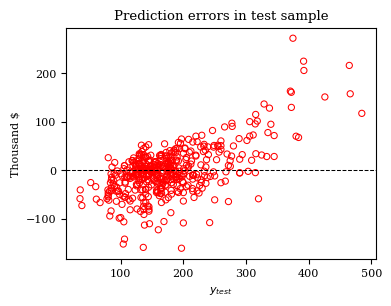

In [26]:
plt.scatter(y_test, errors, s=20, lw=0.75, color='none', edgecolor='red')
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'Thousand $')
plt.title('Prediction errors in test sample')

***
### Using scikit-learn pipelines

As you just saw, additional transformation steps before fitting the model can be tedious and error-prone (we might, for example, forget to transform the test data before computing predictions for the test sample). For this reason, `scikit-learn` implements a feature called "pipelines" which allows us to combine multiple transformations and a final estimation step. For this to work, all steps in the pipeline except for the last must support `fit()` and `transform()` methods, and the final step in the pipeline should be an estimator such as `LinearRegression` (for details, see the [section on pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline) in the `scikit-learn` user guide).

There are two ways to construct a pipeline:

1. Create an instance of the 
    [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class and specify the steps as name-value pairs.
2. Use the 
    [`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) convenience function, which sets a default name for each step.

The first approach requires a list of tuples, where each tuple contains an (arbitrary) name and an object that implements the actions taken at this step. To compose a pipeline that creates polynomial features and fits a linear model to them, we therefore proceed as follows:

In [27]:
from sklearn.pipeline import Pipeline

# Create pipeline with two steps
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('lr', LinearRegression(fit_intercept=False))
])

# visualize pipeline (interactive notebook only)
pipe

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('lr', LinearRegression(fit_intercept=False))])

In an interactive notebook, printing the `pipe` object will generate a visualization which contains details for each step (some editors such as Visual Studio Code even make this visualization interactive).
To transform and fit the model in a single call, we simply need to invoke the `fit()` method. For example, using the training data from above, we run

In [28]:
# transform and fit in a single step
pipe.fit(X_train, y_train)

print(f'Coefficients: {pipe.named_steps.lr.coef_}')

Coefficients: [-2.35826935e+01  1.15491351e+00  6.82427251e-02  8.04784529e-04
 -2.68131126e-04 -1.18034716e-06]


The alternative approach is to construct the pipeline using 
[`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html).
For this to work, we only need to pass the objects that constitute the individual steps of a pipeline as follows:

In [29]:
from sklearn.pipeline import make_pipeline

# Simplified pipeline creation
pipe = make_pipeline(
    PolynomialFeatures(degree=2), 
    LinearRegression(fit_intercept=False)
)
    
# transform and fit model in single step
pipe.fit(X_train, y_train)

# print default names assigned to each step
pipe.named_steps

{'polynomialfeatures': PolynomialFeatures(),
 'linearregression': LinearRegression(fit_intercept=False)}

The function assigns default names to each step which are printed above (basically, these are just lowercase versions of the class defining a step). These names are occasionally required to retrieve information for a specific step.
To demonstrate that the pipeline generates results that are equivalent to our manual implementation, we conclude this section by recreating the error plot from above.

Text(0.5, 1.0, 'Prediction errors in test sample')

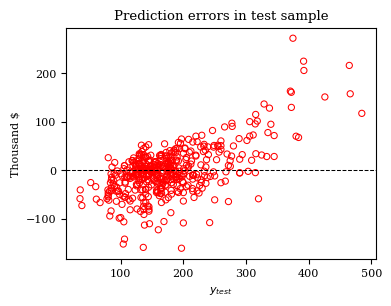

In [30]:
# Predict test responses in a single step. No manual transformation required!
y_test_hat = pipe.predict(X_test)

# Compute prediction errors
errors = y_test - y_test_hat

plt.scatter(y_test, errors, s=20, lw=0.75, color='none', edgecolor='red')
plt.axhline(0.0, lw=0.75, ls='--', c='black')
plt.xlabel(r'$y_{test}$')
plt.ylabel(r'Thousand $')
plt.title('Prediction errors in test sample')

***
### Evaluating the model fit

So far, we evaluated models only based on the visual inspection of the prediction errors. A more systematic approached uses one of several common metrics listed below. These become particularly relevant for models with hyperparameters, i.e., additional parameters that are particular to the estimation technique but are not included in the model as such.
We can use these metrics to select optimal hyperparameters, as we demonstrate later in the lecture.

One of the commonly used metrics to evaluate models is the *mean squared error (MSE)*, defined as 
$$
MSE = \frac{1}{N} \sum_{i=1}^N \bigl(y_i - \widehat{y}_i\bigr)^2
$$
which computes the average squared prediction error $y - \widehat{y}$. The magnitude of the MSE is usually hard to interpret, so we often compute the *root mean squared error (RMSE)*,
$$
RMSE = \sqrt{MSE} = \left(\frac{1}{N} \sum_{i=1}^N \bigl(y_i - \widehat{y}_i\bigr)^2 \right)^{\frac{1}{2}}
$$
which can be interpreted in units of the response variable $y$. Lastly, another measure of a model's fit is the
*coefficients of determination* or $R^2$, which is a normalized version of the MSE and usually takes on values between $[0,1]$. The $R^2$ is defined as 
$$
R^2 = 1 - \frac{MSE}{\widehat{Var}(y)}
$$
where $\widehat{Var}(y)$ is the sample variance of the response $y$.
Intuitively, an $R^2$ of 1 means that the model predicts the response for each observation perfectly (which is unlikely),
whereas an $R^2$ of 0 implies that the model possesses no explanatory power relative to a model that includes only the sample mean. Note that in a test sample, the $R^2$ could even be negative.

While these measures are easy to implement ourselves, we can just as well use the functions provided in `scikit-learn.metrics` to do the work for us: 

-   [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) for the MSE;
-   [`root_mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html) for the RMSE; and
-   [`r2_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score) for the $R^2$.

To illustrate, we continue with the example from above and compute these statistics using the original and predicted target values on the test sample:

In [31]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_test_hat)

# Mean squared error (MSE)
rmse = root_mean_squared_error(y_test, y_test_hat)

# Coefficient of determination (R²)
r2 = r2_score(y_test, y_test_hat)

print(f'Mean squared error: {mse:.1f}')
print(f'Root mean squared error {rmse:.1f}')
print(f'Coefficient of determination (R^2): {r2:.2f}')


Mean squared error: 2666.8
Root mean squared error 51.6
Coefficient of determination (R^2): 0.47


Since we estimated a model with intercept, the $R^2 = 0.47$ implies that the model explains 47% of the variance in the test sample.

***
## Optimizing hyperparameters with cross-validation

### Outline of hyperparameter tuning

Previously, we discussed some ways to evaluate the model fit (MSE and R²) but did not specify what to to with this information. In this section, we demonstrate how we can use these measures to tune parameters which govern the estimation process, such as the polynomial degree from the previous section. Such parameters are usually called *hyperparameters* to clearly distinguish them from the parameters that are estimated by the model (e.g., the coefficients of a linear model).

Tuning hyperparameters, estimating the model and evaluating its generalizability cannot be done based on the same data set, as these steps then become interdependent (for the same reason we don't want to evaluate the model fit on the training sample as this would lead to overfitting). To this end, in machine learning we often split the data intro *three* parts: the training, validation and test data sets. Models are estimated on the training sample, the choice of hyperparameters is determined based on the validation sample and model generalisability is determined based on the test sample which was not used in estimation or tuning at all.

However, because we might not have enough data to split the sample this way, we usually perform so-called *cross-validation* which is illustrated in the figure below:

1. We split the overall data set into training and test sub-samples. 
2. The training data set is further split into $K$ so-called *folds*.
    1. For each $k = 1,\dots,K$, a smaller training sample is formed by excluding
        the $k$-th fold and estimating the model on the remaining $K-1$ folds.
        We then compute the chosen metric of model fit on the $k$-th fold 
        and store the result.
    2. After cycling through all $K$ folds, we have $K$ values of our desired
        metric, which we then average to get our final measure.
        Hyperparameters are tuned by minimizing (or maximizing) this averaged
        metric.
    
3.  Once hyperparameter tuning is complete, we evaluate the model on
    the test data set.

![CV split](cv_split.svg)

In this unit we will skip the final step of assessing generalisability on the test data set. Consequently, when running cross-validation, we will only use training/validation data sets and we will use the terms "validation" and "test" interchangeably.

The `scikit-learn` 
[documentation](https://scikit-learn.org/stable/modules/cross_validation.html) contains a wealth of additional information on cross-validation. Another method to perform hyperparameter tuning is 
[grid search](https://scikit-learn.org/stable/modules/grid_search.html) 
which we won't cover in this unit.

### Example: Tuning of the polynomial degree

To illustrate the concept, we demonstrate the procedure outlined above by tuning the polynomial degree for the example covered in the previous section by minimizing the root mean squared error (RMSE).

We recreate the data set in the same way as before, using `LivingArea` and `LotArea` as explanatory variables.

In [32]:
import pandas as pd

df = pd.read_csv(f'{DATA_PATH}/ames_houses.csv')

features = ['LivingArea', 'LotArea']
target = 'SalePrice'

y = df[target]
X = df[features]

We now iterate over the candidate polynomial degrees $d = 0,\dots,4$ and apply $k$-fold cross-validation with 10 folds. There is no need to manually split the sample into training and validation/test sub-sets. Instead, we use the 
[`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
class to automatically create the splits for us. Once we have created an instance with the desired number of folds, e.g., `KFold(n_splits=10)`, we can call the `split()` method which iterates trough all possible combinations of training and test data sets and returns the array indices for each.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

degrees = np.arange(5)

rmse_mean = []

for d in degrees:

    # Create pipeline to transform and fit the model. Pipeline depends
    # on polynomial degree!
    pipe = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=d, include_bias=True)),
        ('lr', LinearRegression(fit_intercept=False))
    ])

    rmse_fold = []

    # Create 10 folds
    folds = KFold(n_splits=10)

    # Iterate through all combinations of training/test data
    for itrain, itest in folds.split(X, y):

        # Extract training data for this split
        X_train = X.iloc[itrain]
        y_train = y.iloc[itrain]

        # Extract test (or validation) data for this split
        X_test = X.iloc[itest]
        y_test = y.iloc[itest]

        # Fit model on training data for given degree
        pipe.fit(X_train, y_train)

        # Predict response on test data
        y_test_hat = pipe.predict(X_test)

        # Compute RMSE as model fit measure
        rmse = root_mean_squared_error(y_test, y_test_hat)

        # Store RMSE for current split
        rmse_fold.append(rmse)

    # Store average MSE for current polynomial degree
    rmse_mean.append(np.mean(rmse_fold))
    
# Convert to NumPy array
rmse_mean = np.array(rmse_mean)

# Print average RMSE for all polynomial degrees
rmse_mean

array([ 79.02025214,  55.26849841,  55.22858262,  54.89854057,
       476.46767757])

This code returns an array of 5 averaged RMSEs, one for each $d = 0, \dots, 4$. We can now find the optimal $d$ by picking the one which has the lowest mean squared error in the test samples using the
[`argmin()`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html)
function which returns the *index* of the smallest array element.

In [34]:
# Find index of polynomial degree with smallest RMSE
imin = np.argmin(rmse_mean)

# RMSE-minimising polynomial degree
dmin = degrees[imin]

print(f'Polynomial degree with minimum RMSE: {dmin}')

Polynomial degree with minimum RMSE: 3


Finally, it is often instructive to visualise how the RMSE evolves as a function of the hyperparameter we want to tune.

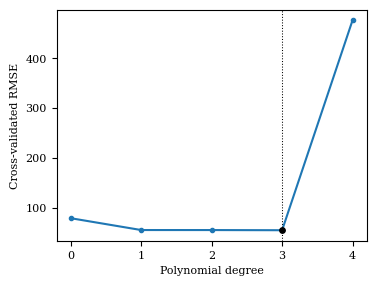

In [35]:
plt.plot(degrees, rmse_mean, marker='o', ms=3)
plt.xlabel('Polynomial degree')
plt.ylabel('Cross-validated RMSE')
plt.scatter(degrees[imin], rmse_mean[imin], s=15, c='black', zorder=100)
plt.xticks(degrees)
plt.axvline(imin, ls=':', lw=0.75, c='black')

Here we see that for $d=0$ (the intercept-only model), the model underfits the data leading to a high prediction error. However, higher $d$'s do not always translate into a better fit. For $d = 4$, the model vastly overfits the data, resulting in poor performance in the test sample and a very large RMSE.

### Automating cross-validation

The code implemented above to run cross-validation was needlessly complex even though we leveraged the `KFold` class to do the sample splitting for us. Fortunately, `scikit-learn` provides us with even more convenience functions that further simplify this process.
For example, if we want to perform tuning based on a single score (such as the root mean squared error), we can instead use 
[`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). This function requires us to specify an estimator (or a pipeline), the number of folds to use for cross-validation (`cv=10`)
and the metric to evaluate. For example, if we want to compute the RMSE, we would pass the argument 
`scoring='neg_root_mean_squared_error'`. Note that the function returns the *negative* RMSE which we need to correct manually.

See the 
[documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
for a complete list of valid metrics that can be passed as `scoring` arguments. Alternatively, `scikit-learn` lists available metrics by running

```python
import sklearn.metrics
sklearn.metrics.get_scorer_names()
```

The following code re-implements the k-fold cross-validation from earlier
using `cross_val_score()`:

In [36]:
from sklearn.model_selection import cross_val_score

degrees = np.arange(5)

rmse_mean = []
rmse_std = []

for d in degrees:

    # Create pipeline for current polynomial degree
    pipe = Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=d, include_bias=True)),
        ('lr', LinearRegression(fit_intercept=False))
    ])

    # Compute negative RMSE for all 10 folds
    score = cross_val_score(
        pipe, 
        X, y, 
        scoring='neg_root_mean_squared_error', 
        cv=10
    )

    # Function returns NEGATIVE RMSE, correct this here!
    rmse_mean.append(np.mean(-score))
    
# Convert to NumPy array
rmse_mean = np.array(rmse_mean)

# Print average RMSE for all polynomial degrees
rmse_mean

array([ 79.02025214,  55.26849841,  55.22858262,  54.89854057,
       476.46767757])

The RMSE-minimising degree is of course the same as before:

In [37]:
imin = np.argmin(rmse_mean)
dmin = degrees[imin]

print(f'Polynomial degree with min. RMSE: {dmin}')

Polynomial degree with min. RMSE: 3


`scikit-learn` provides an even more automated API to perform the cross-validation using the function 
[`validation_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html). 
We study this alternative in an optional exercise below.

***
## Dealing with categorical data (optional)

So far in this unit, we only dealt with continuous data, i.e., data that can take on (almost any) real value. However, many data sets contain categorical variables which take on a finite number of admissible values or even binary variables (often called dummy or indicator variables) which can be either 0 or 1. Dealing with such data in `scikit-learn` is less straightforward than in most other software packages, so in this section we illustrate how to work with categorical variables.

To do this, we again load the Ames house data which contains several categorical and binary variables.

In [38]:
import pandas as pd

df = pd.read_csv(f'{DATA_PATH}/ames_houses.csv')

For example, consider the `BuildingType` variable, which (in this simplified version of the data) takes on three values, 'Single-family', 'Townhouse' and 'Two-family' and has on top a few missing observations. We use the 
[`value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html) method to tabulate the number of observations falling into each category. The argument `dropna=False` also includes the number of missing values in the tabulation.

In [39]:
df['BuildingType'].value_counts(dropna=False).sort_index()

BuildingType
Single-family    1220
Townhouse         114
Two-family         52
NaN                74
Name: count, dtype: int64

There are several ways to deal with such data (see the official
[documentation](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) for details). 
First, since the data are stored as strings, we could use 
[`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
to map these strings to integers.

In [40]:
from sklearn.preprocessing import OrdinalEncoder

# Drop rows with NA
df = df.dropna(subset='BuildingType')

enc = OrdinalEncoder()

# Transform string variable into integers
bldg_int = enc.fit_transform(df[['BuildingType']])

# Print unique values and histogram
print(f'Unique values: {np.unique(bldg_int)}')
print(f'Histogram: {np.bincount(bldg_int.astype(int).flatten())}')


Unique values: [0. 1. 2.]
Histogram: [1220  114   52]


This, however, is still not particularly useful if we want to use these categories as explanatory variables in a `LinearRegression` because `scikit-learn` will simply treat them as a continuous variable that happens to take on the values 0, 1 or 2. There is nothing to enforce the categorical nature of this data.

An alternative encoding strategy is to create a binary dummy variable for each possible value of a categorical variable. This is achieved using the 
[OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) 
transformation as illustrated by the following code:

In [41]:
from sklearn.preprocessing import OneHotEncoder

# Drop rows with NA
df = df.dropna(subset='BuildingType')

# List of unique categories
bldg_uniq = list(np.sort(df['BuildingType'].unique()))

# Create dummy variable encoder
enc = OneHotEncoder(categories=[bldg_uniq], sparse_output=False)

# Convert string variable into binary indicator variables
bldg_dummies = enc.fit_transform(df[['BuildingType']])

When creating a `OneHotEncoder`, we can optionally pass the list of possible values using the `categories` argument. By default, this transformation returns a sparse matrix since each row will have exactly one element that is 1 while the remaining elements are 0. Using a sparse matrix saves memory but makes interacting with the resulting array more cumbersome. For small data sets, there is no need to use sparse matrices.

The transformed data now looks as follows:

In [42]:
# Print first 5 rows
bldg_dummies[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In this particular example, the first five observations fall into the first category, hence the first column contains ones while the remaining elements are zero.

We can sum the number of ones in each column to verify that the frequency of each category remains the same:

In [43]:
bldg_dummies.sum(axis=0)

array([1220.,  114.,   52.])

The category labels taken from the original data are stored in the `categories_` attribute:

In [44]:
enc.categories_[0]

array(['Single-family', 'Townhouse', 'Two-family'], dtype=object)

Now that we have converted the categories into a dummy matrix, we can append it to the continuous explanatory variables and fit the linear model as usual:

In [45]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Name of dependent variable
target = 'SalePrice'
# Continuous explanatory variables to include
continuous = ['LivingArea', 'LotArea']

y = df[target].to_numpy()
# Feature matrix with dummies appended
X = np.hstack((df[continuous].to_numpy(), bldg_dummies))

# Create and fit linear model
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)

# Create DataFrame containing estimated coefficients
labels = continuous + [f'BuildingType: {s}' for s in enc.categories_[0]]

coefs = pd.DataFrame(lr.coef_, index=labels, columns=['Coef'])
coefs

,Coef
LivingArea,1.152606
LotArea,0.008386
BuildingType: Single-family,12.173902
BuildingType: Townhouse,37.735490
BuildingType: Two-family,-41.842492


Finally, you should be aware that `pandas` provides the function
[`get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) which accomplishes something very similar to `OneHotEnconder` but may not work as well with the `scikit-learn` API.

In [46]:
pd.get_dummies(df['BuildingType']).head(5)

,Single-family,Townhouse,Two-family
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


***
## Optional exercises

### Exercise 1: Optimizing hyperparameters with validation curves

In the lecture, we explored two ways to perform cross-validation. This exercise guides you through the process of automating even more of these steps using the `scikit-learn` API.

Consider the following model where $y$ is a non-linear trigonometric function of $x$ and includes an additive error term $\epsilon$,
$$
y_i = f(x_i) + \epsilon_i\,, \qquad f(x) = \sin\bigl(2 \pi (x + 0.1) \bigr)
$$
and $x$ and $\epsilon$ are assumed to be independent.

1.  Create a sample of $N=100$ realizations of $(x_i, \epsilon_i)$ using a seed 1234 for the random number generator. 
    Draw the $x_i$ from the standard uniform distribution on $[0, 1]$ and 
    let $\epsilon \stackrel{\text{iid}}{\sim} N(0, 0.5^2)$.
    Compute $y_i$ according to the equation above.

    *Hint:* The sine function and the constant $\pi$ are implemented as `np.sin()` and `np.pi` in NumPy.
    
2.  Create a sample scatter plot of $(x_i, y_i)$ and add a line showing the true relationship between $x$ and $y$ 
    (without measurement error).

3.  Assume you don't know the true model and you want to fit the target $y$ to a polynomial in $x$. 
    To this end, create a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    that performs the polynomial transformation and the fitting of the linear model. You can use any value for 
    `PolynomialFeatures(degree=...)` at this point.

4.  Use the convenience function 
    [`validation_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
    to compute the MSE for *each* $d = 0,\dots,15$ and 10 cross-validation splits in a single call:

    ```python
    train_scores, test_scores = validation_curve(
        estimator=...,
        ...,
        param_name='polynomialfeatures__degree',
        param_range=degrees,
        scoring='neg_mean_squared_error', 
        cv=10
    )
    ```

    To do this, the argument `estimator` specifies the model to use (i.e., the pipeline you created 
    in the previous part), `param_name` specifies which parameter needs to be varied, and `param_range` determines
    the set of parameter values that are evaluated. The `scoring` argument determines which metric is computed 
    and returned.

    Since our estimator is a pipeline, the parameter name needs to be specified as `'STEP__ARGUMENT'` where `STEP` is
    the name of the step in the pipeline we defined (see 
    [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    for details), and `ARGUMENT` determines the argument name to be varied when re-creating the pipeline,
    which in our case is `degree`.

    *Hint:* For pipelines created using 
    [`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html),
    the name of each step in the pipeline is the class name converted to lower case, i.e., for 
    `PolynomialFeatures` the step name is `polynomialfeatures`.
    In this case, `validation_curve()` needs to be called with the argument
    `param_name='polynomialfeatures__degree'`.

5.  [`validation_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
    returns two arrays which contain the scores computed on the training and test sets, respectively.
    The first dimension of each array corresponds to each parameter from `param_range` and the second dimension
    corresponds to individual folds used in the cross-validation.

    Compute the average MSE for each polynomial degree. Report the polynomial degree at which this metric is minimized,
    and plot the average MSE on the $y$-axis against all polynomial degrees on the $x$-axis to visualize your results.

6.  Recreate the graph from Part (2) and add the predicted values from the model with optimal polynomial degree you found.


The `scikit-learn` 
[documentation](https://scikit-learn.org/stable/modules/learning_curve.html) 
provides additional information on validation curves which you might want to consult.



***
## Solutions

### Exercise 1: Optimizing hyperparameters with validation curves

#### Part 1: Creating the sample

We first define the function $f(x)$ that represents the true relationship.

In [47]:
import numpy as np

# True function (w/o errors)
def fcn(x):
    return np.sin(2.0 * np.pi * (x + 0.1))

We then draw a sample of size 100 using the respective distributions for $x_i$ and $\epsilon_i$.

In [48]:
from numpy.random import default_rng

# Initialise random number generator
rng = default_rng(seed=1234)

# Sample size
N = 100

# Randomly draw explanatory variable x
x = rng.uniform(size=N)
epsilon = rng.normal(scale=0.5, size=N)
y = fcn(x) + epsilon

#### Part 2: Plotting the sample

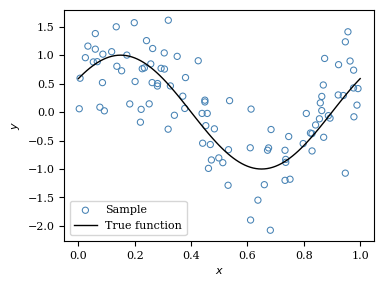

In [49]:
import matplotlib.pyplot as plt

# Plot raw data
plt.scatter(x, y, s=20, color='none', edgecolor='steelblue', lw=0.75, label='Sample')

# Plot true function on uniformly spaced grid
xvalues = np.linspace(0.0, 1.0, 101)
plt.plot(xvalues, fcn(xvalues), color='black', lw=1.0, label='True function')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

#### Part 3: Creating a pipeline

We can create a pipeline using two equivalent ways, using either
[`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) or
[`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create pipeline. The degree value does not matter at this point, will be
# automatically updated.
pipe = make_pipeline(
    PolynomialFeatures(
        degree=0, 
        include_bias=True
    ),
    LinearRegression(fit_intercept=False)
)

Alternatively, we could have created the pipeline using 
[`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
which allows us to explicitly assign names to each pipeline step. We choose names which are the same as the default values assigned by 
[`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html):

In [51]:
from sklearn.pipeline import Pipeline

# Create pipeline, explicitly specifying step names
pipe = Pipeline(
    [
        ('polynomialfeatures', PolynomialFeatures(degree=0, include_bias=True)),
        ('linearregression', LinearRegression(fit_intercept=False)),
    ]
)

#### Part 4: Computing the MSE for each hyperparameter

To use 
[`validation_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html),
we need to correctly specify the `param_name` argument. In our case this is given by 
`'polynomialfeatures__degree'` since we are asking the function to vary the argument `degree` of the pipeline step called
`polynomialfeatures`. Note that the `__` serves as a delimiter between the pipeline step name and the argument name.

In [52]:
from sklearn.model_selection import validation_curve

# Set of polynomial degrees to cross-validate
degrees = np.arange(16)

# Compute the MSEs for each degree and each split, returning arrays of 
# size 15 x 10.
train_scores, test_scores = validation_curve(
    estimator=pipe,
    X=x[:, None], y=y,
    param_name='polynomialfeatures__degree',
    param_range=degrees,
    scoring='neg_mean_squared_error', 
    cv=10
)

# Compute mean and std for each degree (scores returned by function are 
# NEGATIVE MSEs)
mse_mean = np.mean(-test_scores, axis=1)
mse_std = np.std(-test_scores, axis=1)

#### Part 5: Determine optimal polynomial degree

The optimal cross-validated polynomial degree is the one at which the average MSE is minimized:

In [53]:
imin = np.argmin(mse_mean)
dmin = degrees[imin]

print(f'Polynomial degree with min. MSE: {dmin}')

Polynomial degree with min. MSE: 5


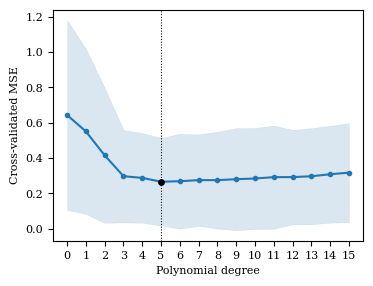

In [54]:
plt.plot(degrees, mse_mean, marker='o', ms=3)

plt.fill_between(degrees, mse_mean-2.0*mse_std, mse_mean+2.0*mse_std, 
    lw=0.25, color='steelblue', alpha=0.2, zorder=-1)

plt.xlabel('Polynomial degree')
plt.ylabel('Cross-validated MSE')
plt.scatter(degrees[imin], mse_mean[imin], s=15, c='black', zorder=100)
plt.xticks(degrees)
plt.axvline(imin, ls=':', lw=0.75, c='black')

#### Part 6: Plot predicted values using optimal hyperparameter

We need to re-fit the model using the optimal polynomial degree. For this, we recreate the pipeline, fit the model and compute the model prediction on a grid of $x$-values.

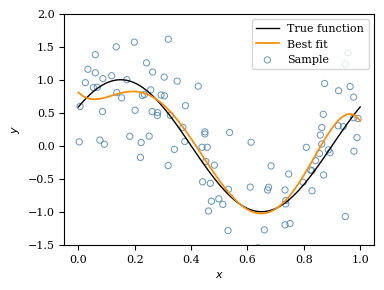

In [55]:
pipe = make_pipeline(
    PolynomialFeatures(degree=dmin, include_bias=True),
    LinearRegression(fit_intercept=False),
)

pipe.fit(x[:, None], y)

# X-values used for prediction
xvalues = np.linspace(0.0, 1.0, 101)
# Fit model
y_hat = pipe.predict(xvalues[:, None])

# Plot true relationship (w/o errors)
plt.plot(xvalues, fcn(xvalues), color='black', lw=1.0, label='True function')

# Plot best fit
plt.plot(xvalues, y_hat, color='darkorange', lw=1.25, zorder=10, label='Best fit')

# Plot sample
plt.scatter(
    x, y, s=20, color='none', edgecolor='steelblue', lw=0.75, alpha=0.8, label='Sample'
)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-1.5, 2.0)
plt.legend(loc='upper right')